# Import Libraries

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Preprocess

In [2]:
# Get the preprocessed X and y from the data.
def get_X_y():
    # Read in data.
    df = pd.read_csv('data/Boats_Cleaned_dataset.csv')
    df = df.fillna(0)

    # Delete selected rows with NaN.
    df = df[pd.to_numeric(df['zip'], errors='coerce').notnull()]
    df['zip'] = df['zip'].astype(int)
    df = df.drop(df[df['zip']==0].index)
    df = df.drop(df[df['engineCategory']==0].index)
    df = df.drop(df[df['beam_ft']==0].index)
    df = df.drop(df[df['totalHP']==0].index)

    # Delete selected columns with NaN
    df = df.drop(['Unnamed: 0','created_date','id','maxEngineYear','minEngineYear','dryWeight_lb', 'make', 'model','city','sellerId'],axis=1)

    # Define features and target.
    X0 = df.drop(['price'], axis=1)
    y0 = df.price

    # Standardize
    X_n = X0.select_dtypes(include='number')
    X_c = X0.select_dtypes(exclude='number')
    X_n = StandardScaler().set_output(transform='pandas').fit_transform(X_n)

    # Hot Encode
    X_c = pd.get_dummies(X_c, drop_first = False) #dropped first
    df = pd.concat([X_n,X_c,y0],axis=1)

    # Redefine features and target
    X = df.drop(['price'],axis=1)
    y = df.price

    return (X, y)

In [3]:
X, y = get_X_y()
print(X.shape)

(5752, 142)


Text(0.5, 0, 'Price ($)')

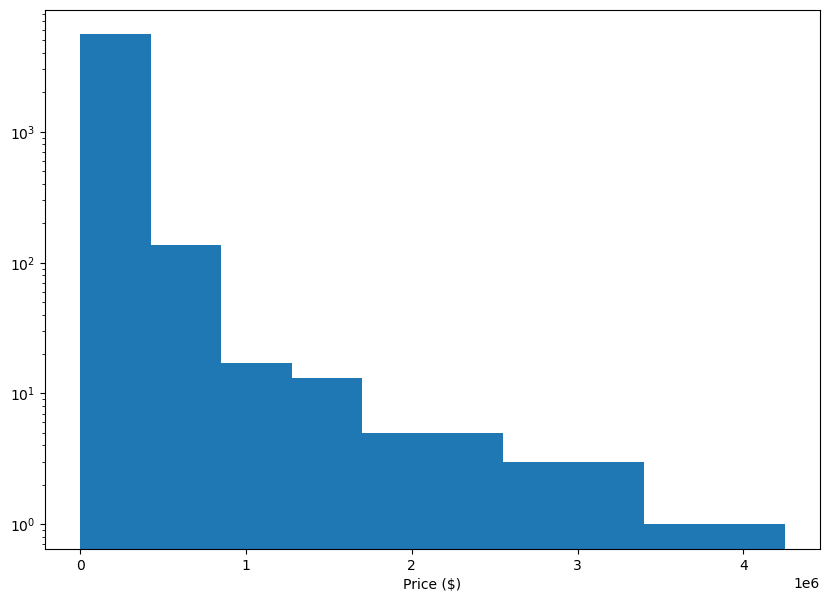

In [36]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
ax.hist(y, log=True)
ax.set_xlabel("Price ($)")

[Text(0, 1, 'Price ($)')]

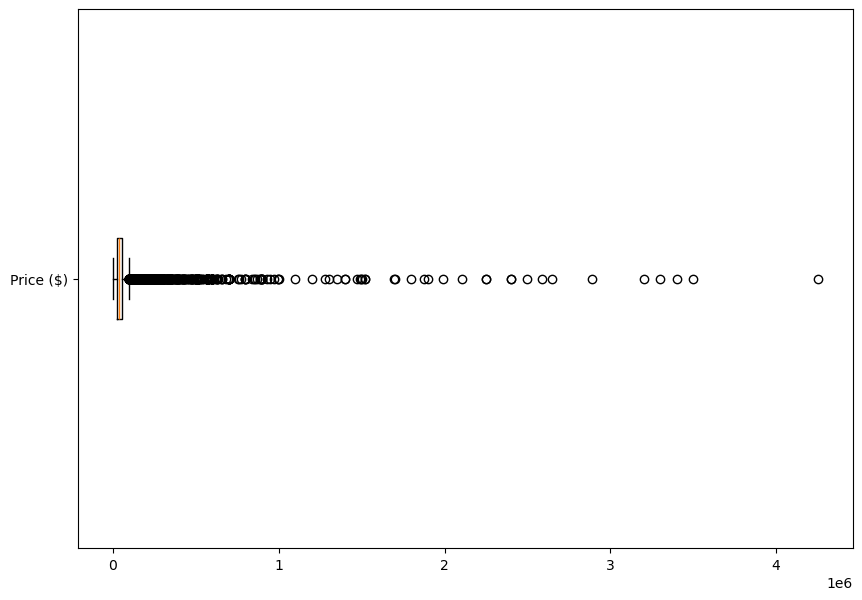

In [40]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(y, notch=None, vert=0, patch_artist=None, widths=None)
ax.set_yticklabels(['Price ($)'])

[Text(0, 1, 'Price ($)')]

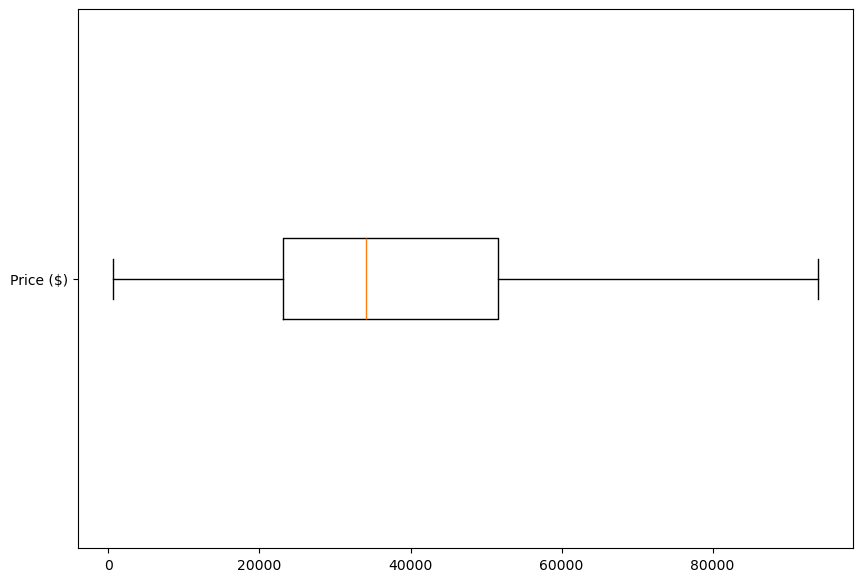

In [43]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(y, notch=None, vert=0, patch_artist=None, widths=None, showfliers=False)
ax.set_yticklabels(['Price ($)'])

# Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Feature Engineer, d=2

In [5]:
poly = PolynomialFeatures(2,interaction_only=False,include_bias=False)
Xe_train = poly.fit_transform(X_train)
cols = poly.get_feature_names_out(X_train.columns)
Xe_train = pd.DataFrame(Xe_train, columns=cols)
# Xe_train = stnd.fit_transform(Xe_train)
Xe_train['bias'] = 1
print(Xe_train.shape)
Xe_train.head()

Xe_test = poly.fit_transform(X_test)
cols = poly.get_feature_names_out(X_test.columns)
Xe_test = pd.DataFrame(Xe_test, columns=cols)
# Xe_test = stnd.transform(Xe_test)
Xe_test['bias'] = 1
Xe_test.head()

(4601, 10296)


,year,length_ft,beam_ft,numEngines,totalHP,zip,created_month,created_year,type_power,type_sail,...,state_VT state_WA,state_VT state_WI,state_VT state_WV,state_WA^2,state_WA state_WI,state_WA state_WV,state_WI^2,state_WI state_WV,state_WV^2,bias
0,0.459450,0.367392,-0.046988,-0.384248,-0.022364,0.016842,-0.624789,0.669243,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.050196,-0.588427,-0.278693,-0.384248,-0.349689,-1.443551,1.187661,-0.442682,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.357137,-0.800832,-0.697436,-0.384248,-0.677015,-1.698533,0.885586,-1.554608,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.357137,-0.800832,-0.069321,-0.384248,-0.563162,0.924080,1.791810,-2.666533,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.459450,-0.269821,-0.094445,1.745032,0.973844,-0.594695,1.791810,-0.442682,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Use Lasso for feature selection

In [7]:
# regularize
grid = {'alpha':[100, 250, 380, 390, 400, 700, 1000]}
lasso = Lasso()
lassoCV = GridSearchCV(lasso,param_grid=grid,return_train_score=True)
# lassoCV = cross_validate(lasso, return_train_score=True)
lassoCV.fit(Xe_train,y_train)

print()
print('best alpha =',lassoCV.best_params_, '  valid R2 =',lassoCV.best_score_.round(3))

C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.641e+11, tolerance: 1.509e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e+12, tolerance: 1.522e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi


best alpha = {'alpha': 390}   valid R2 = 0.803


C:\Users\schrocjq\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e+10, tolerance: 1.707e+10
  model = cd_fast.enet_coordinate_descent(


# Show alpha optimization

length_ft boatClass_power-house           -72589.201454
totalHP state_OH                          -40400.604071
length_ft hullMaterial_aluminum           -31394.376608
totalHP boatClass_power-expresscruiser    -28118.409778
year boatClass_power-highperf             -19820.430516
                                              ...      
length_ft                                  58307.088272
totalHP boatClass_power-mega               62066.984276
totalHP boatClass_power-pilot              67923.304265
year totalHP                               70016.246072
condition_new fuelType_diesel             337539.533625
Length: 10296, dtype: float64

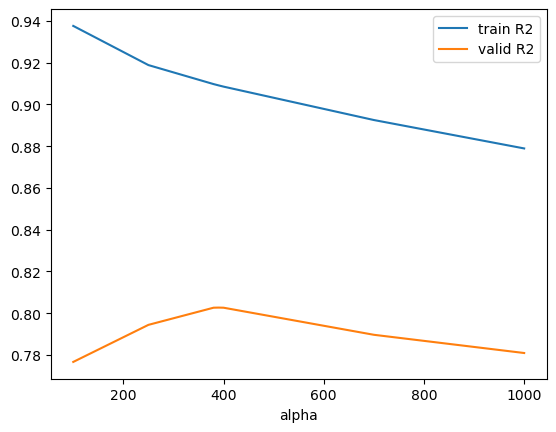

In [8]:
results = pd.DataFrame()
results['alpha'] = (grid['alpha'])
results['train R2'] = lassoCV.cv_results_['mean_train_score']
results['valid R2']  = lassoCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='alpha',y='train R2')
results.plot.line(x='alpha',y='valid R2',ax=ax1)

lasso = lassoCV.best_estimator_
coef = pd.Series(lasso.coef_,index=Xe_train.columns)
coef.sort_values()

# Lasso test R2

In [9]:
print('Test R2: ', lassoCV.score(Xe_test,y_test))

Test R2:  0.8933933404661998


# Use lasso to remove some features

In [10]:
filtered_coef = coef.drop(coef[coef.apply(lambda x: (x < 0.0001) & (x > -0.0001))].index)
filtered_coef.sort_values()

length_ft boatClass_power-house           -72589.201454
totalHP state_OH                          -40400.604071
length_ft hullMaterial_aluminum           -31394.376608
totalHP boatClass_power-expresscruiser    -28118.409778
year boatClass_power-highperf             -19820.430516
                                              ...      
length_ft                                  58307.088272
totalHP boatClass_power-mega               62066.984276
totalHP boatClass_power-pilot              67923.304265
year totalHP                               70016.246072
condition_new fuelType_diesel             337539.533625
Length: 105, dtype: float64

# Optimize N Estimators random forest for this set

In [75]:
grid = {'n_estimators':[250, 500, 1000, 2000, 4000]}

rf = RandomForestRegressor(max_features = 1/3, max_depth=35)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(Xe_train[filtered_coef.index.to_list()],y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))


         best B = {'n_estimators': 1000}
  validation R2 = 0.838


# Show optimization

Random Forest Regressor
     Optimal Parameters: {'n_estimators': 1000}
     Optimal Valid R2: [0.83073229 0.83511181 0.8376513  0.83375587 0.83462402]


<Axes: xlabel='trees'>

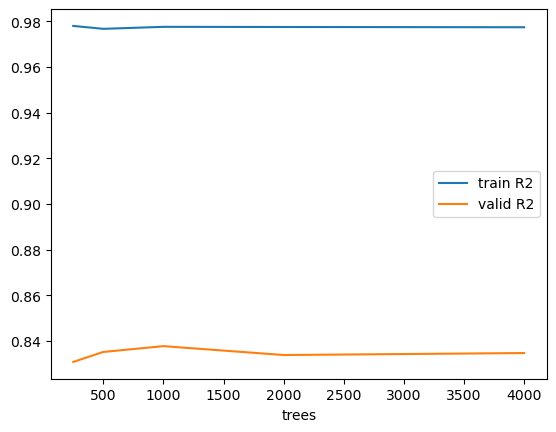

In [78]:
print('Random Forest Regressor')
print('     Optimal Parameters:', rfCV.best_params_)
print('     Optimal Valid R2:', rfCV.cv_results_['mean_test_score'])
results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

# Calculate and Show test R2

In [42]:
# out-of-bag score
rf = RandomForestRegressor(n_estimators=1000, max_depth=35, max_features = 1/3,oob_score=True, random_state=0)
rf.fit(Xe_train[filtered_coef.index.to_list()],y_train)
print('out-of-bag R2 =',rf.oob_score_.round(3))
print()
cv_results = cross_validate(rf,Xe_train[filtered_coef.index.to_list()],y_train,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_valid   = cv_results['test_score'].mean()
print('train R2 (CV) =',R2_trainCV.round(3),'  valid R2 =',R2_valid.round(3))
print()
R2_train = rf.score(Xe_train[filtered_coef.index.to_list()],y_train)
R2_test  = rf.score(Xe_test[filtered_coef.index.to_list()],y_test)
print('     train R2 =',R2_train.round(3),'    test R2 =',R2_test.round(3))

out-of-bag R2 = 0.841

train R2 (CV) = 0.977   valid R2 = 0.837

     train R2 = 0.979     test R2 = 0.931
